# Персонализация предложений для клиентов интернет-магазина

**Цель**

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Задачи**

- Построить модель машинного обучения, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.


- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.


- Используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.


***Описание данных***

**market_file.csv**

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

- id — номер покупателя в корпоративной базе данных.

- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».

- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.

- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.

- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.

- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.

- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

**market_money.csv**

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

- id — номер покупателя в корпоративной базе данных.

- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

- Выручка — сумма выручки за период.

**market_time.csv**

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

- id — номер покупателя в корпоративной базе данных.

- Период — название периода, во время которого зафиксировано общее время.
минут — значение времени, проведённого на сайте, в минутах.

**money.csv**

Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

- id — номер покупателя в корпоративной базе данных.

- Прибыль — значение прибыли.


In [1]:
!pip install phik -q
!pip install -U scikit-learn -q
!pip install shap -q

^C
^C


In [19]:
#библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_curve, auc, f1_score, roc_auc_score, confusion_matrix,
    accuracy_score, precision_score, recall_score, RocCurveDisplay
)
from sklearn.dummy import DummyClassifier
import phik as phk
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap


In [20]:
#константы 
RANDOM_STATE = 42
#настройки
pd.options.display.float_format = '{:,.2f}'.format
sns.set_theme (style='darkgrid')

## Загрузка данных

In [21]:
#Загрузка таблиц
df1 = pd.read_csv('http://code.s3.yandex.net/datasets/market_file.csv')
df2 = pd.read_csv('http://code.s3.yandex.net/datasets/market_money.csv')
df3 = pd.read_csv('http://code.s3.yandex.net/datasets/market_time.csv')
df4 = pd.read_csv('http://code.s3.yandex.net/datasets/money.csv',decimal=",",sep=';')

In [22]:
#общая информация о таблицах

dat_list = [df1, df2, df3, df4]
for i in dat_list:
    display(i.head(5))
    display(i.info())

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                3.40                     5           121               0.00   
1                4.40                     4           819               0.75   
2                4.90                     3           539               0.14   
3                3.20                     5           896               0.99   
4                5.10                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

id               Период  Выручка
0  215348  препредыдущий_месяц     0.00
1  215348        текущий_месяц 3,293.10
2  215348     предыдущий_месяц     0.00
3  215349  препредыдущий_месяц 4,472.00
4  215349        текущий_месяц 4,971.60

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

**Вывод:**
- загружены 4 таблицы;
- все столбцы соответствуют описанию;


## Предобработка

### Таблица №1: market_file.csv


Пропусков нет:

In [23]:
print('Пропусков:',df1.isna().sum().sum())

Пропусков: 0


Полных дубликатов нет:

In [24]:
print('Дубликатов:')
print(df1.duplicated().sum())

Дубликатов:
0


Проблем с типами данных нет:

In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Проверка неявных дубликатов:

In [26]:
df1['id'].duplicated().sum()

0

In [27]:
df1['Покупательская активность'].value_counts()

Покупательская активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

In [28]:
df1['Разрешить сообщать'].value_counts()

Разрешить сообщать
да     962
нет    338
Name: count, dtype: int64

In [29]:
df1['Тип сервиса'].value_counts()

Тип сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

In [30]:
df1['Популярная_категория'].value_counts()

Популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

Выявлен неявный дубликат в "Тип сервиса":

In [31]:
df1.loc[df1['Тип сервиса'] == "стандартт","Тип сервиса"] = 'стандарт'

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично, первый баг в данных обнаружен. Есть ещё два ....
</div>

In [32]:
df1['Тип сервиса'].value_counts()

Тип сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

In [33]:
# косметическая правка - название столбцов
df1 = df1.rename(columns={'Покупательская активность' : 'Покупательская_активность','Тип сервиса' : 'Тип_сервиса',
                    'Разрешить сообщать' : 'Разрешить_сообщать'})

### Таблица №2: market_money.csv


In [34]:
df2.head()

id               Период  Выручка
0  215348  препредыдущий_месяц     0.00
1  215348        текущий_месяц 3,293.10
2  215348     предыдущий_месяц     0.00
3  215349  препредыдущий_месяц 4,472.00
4  215349        текущий_месяц 4,971.60

Проверка пропусков и дубликатов:

In [35]:
print('Пропусков:',df2.isna().sum().sum())

Пропусков: 0


In [36]:
print('Полных дубликатов:')
print(df2.duplicated().sum())

Полных дубликатов:
0


Неявных дубликатов нет:

In [37]:
df2['Период'].value_counts()

Период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

###  Таблица №3: market_time.csv


In [38]:
df3.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

Проверка пропусков и дубликатов:

In [39]:
print('Пропусков:',df3.isna().sum().sum())

Пропусков: 0


In [40]:
print('Полных дубликатов:')
print(df3.duplicated().sum())

Полных дубликатов:
0


In [41]:
df3['Период'].value_counts()

Период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

In [42]:
df3.loc[df3['Период'] == "предыдцщий_месяц","Период"] = 'предыдущий_месяц'

###  Таблица №4: money.csv

In [43]:
df4.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

Проверка пропусков и дубликатов:

In [44]:
print('Пропусков:',df4.isna().sum().sum())

Пропусков: 0


In [45]:
print('Полных дубликатов:')
print(df4.duplicated().sum())

Полных дубликатов:
0


In [46]:
df4['id'].duplicated().sum()

0

## Исследовательский анализ данных

### Статистический анализ market_file


In [47]:
#выделение признаков
num_df1 = df1.select_dtypes(include=['number']).drop('id',axis=1).columns.to_list()  # Числовые признаки
cat_df1 = df1.select_dtypes(include=['object']).columns.to_list()  # Категориальные признаки

**Описательные статистики до обработки выбросов**:

In [48]:
df1[num_df1].describe().T

count   mean    std    min    25%  \
Маркет_актив_6_мес                  1,300.00   4.25   1.01   0.90   3.70   
Маркет_актив_тек_мес                1,300.00   4.01   0.70   3.00   4.00   
Длительность                        1,300.00 601.90 249.86 110.00 405.50   
Акционные_покупки                   1,300.00   0.32   0.25   0.00   0.17   
Средний_просмотр_категорий_за_визит 1,300.00   3.27   1.36   1.00   2.00   
Неоплаченные_продукты_штук_квартал  1,300.00   2.84   1.97   0.00   1.00   
Ошибка_сервиса                      1,300.00   4.19   1.96   0.00   3.00   
Страниц_за_визит                    1,300.00   8.18   3.98   1.00   5.00   

                                       50%    75%      max  
Маркет_актив_6_мес                    4.20   4.90     6.60  
Маркет_актив_тек_мес                  4.00   4.00     5.00  
Длительность                        606.00 806.00 1,079.00  
Акционные_покупки                     0.24   0.30     0.99  
Средний_просмотр_категорий_за_визит   3.00   4.00     6.00  
Неоплаченные_продукты_штук_квартал    3.00   4.00    10.00  
Ошибка_сервиса                        4.00   6.00     9.00  
Страниц_за_визит                      8.00  11.00    20.00

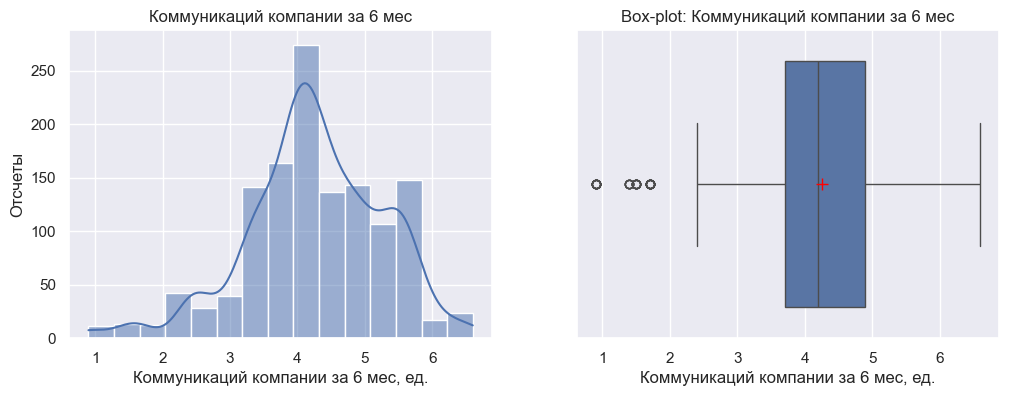

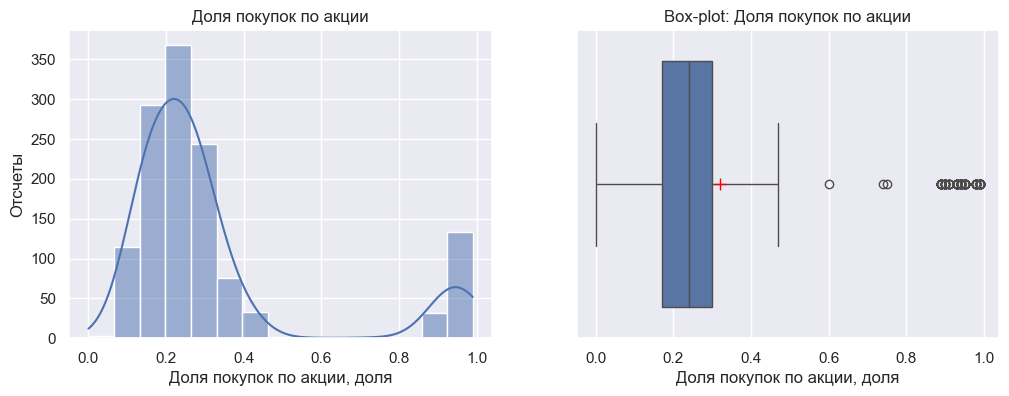

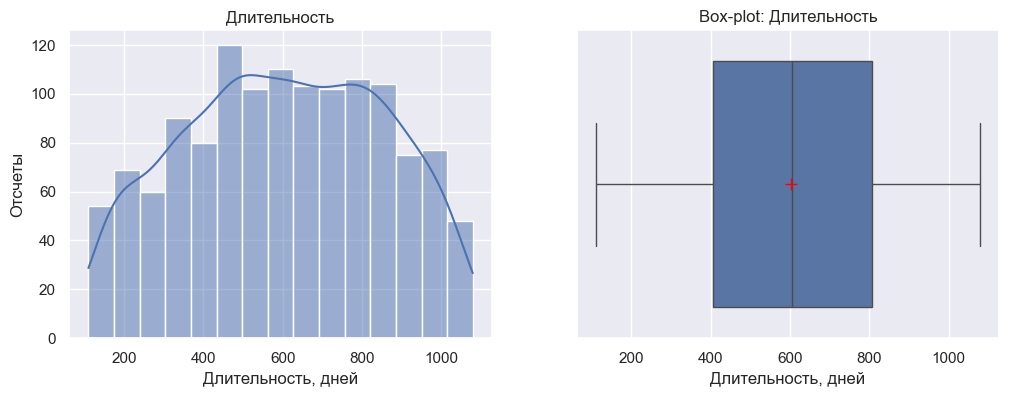

In [49]:
#Построение гипстограм и box-plot
mesur = ['ед.','доля','дней']
names = ['Коммуникаций компании за 6 мес', 'Доля покупок по акции','Длительность']
i = -1
for j in ['Маркет_актив_6_мес','Акционные_покупки','Длительность']:
    i = i + 1 
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 2, 1)
    sns.histplot(df1[j], kde=True,bins=15)
    plt.title('' + names[i] )

    plt.xlabel(names[i] + ', ' + mesur[i])
    plt.ylabel("Отсчеты")
    plt.subplot(1, 2, 2)
    sns.boxplot(data = df1,x=j,orient='horizontal',
            showmeans=True,meanprops={'marker':'+','markeredgecolor':'red','markersize':'9' })
    plt.xlabel(names[i] + ', ' + mesur[i])
    plt.title('Box-plot: '+names[i])
   
    plt.show()



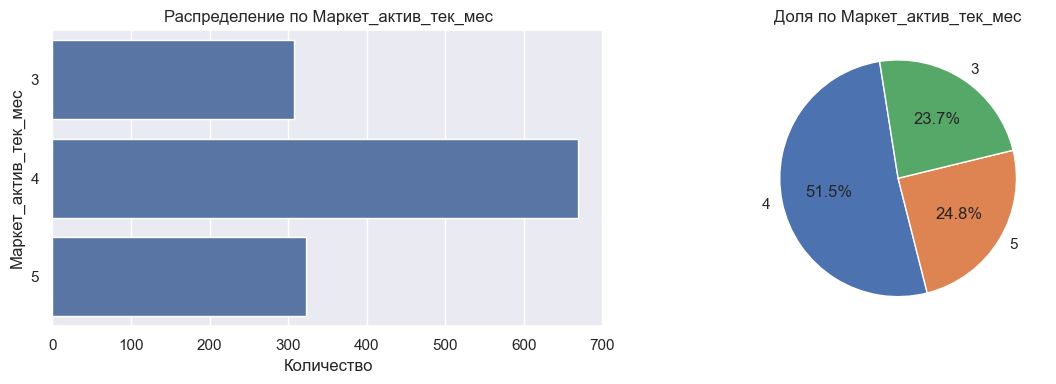

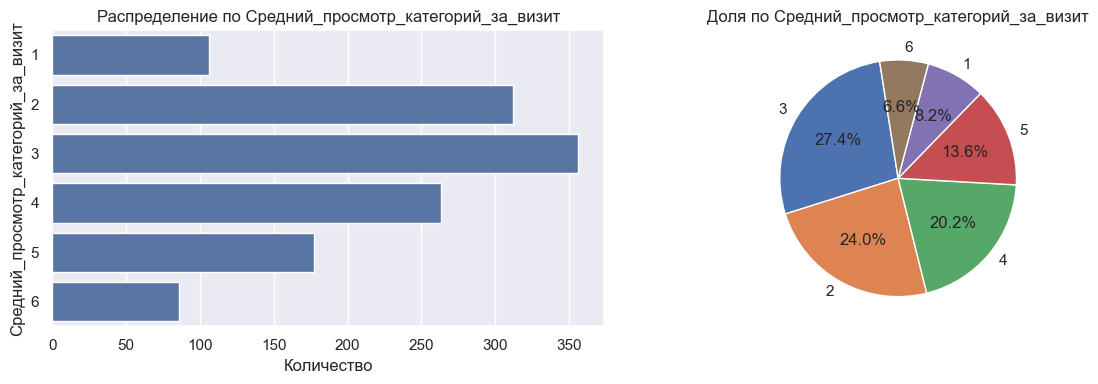

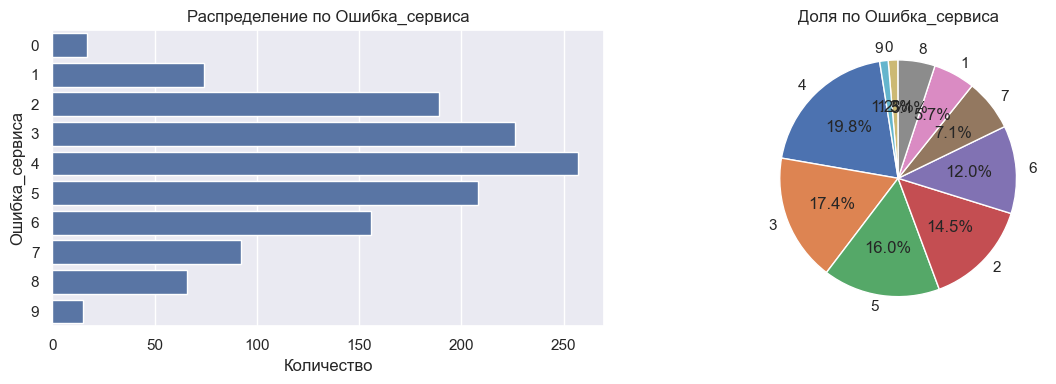

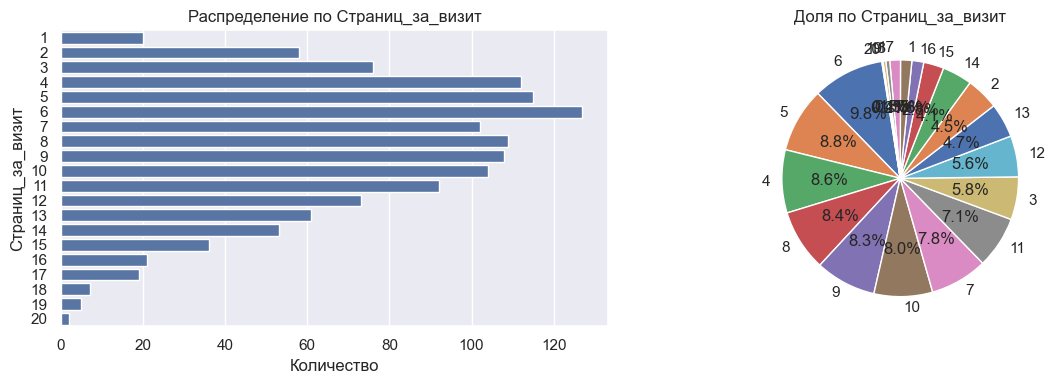

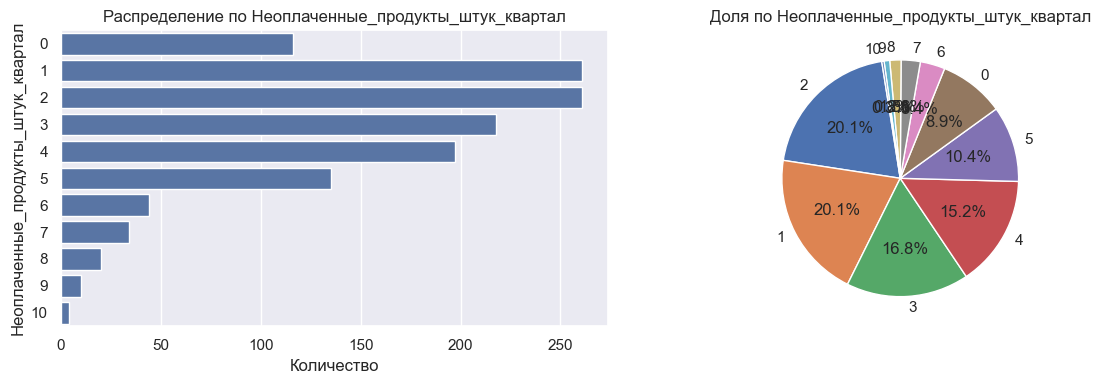

In [50]:
for j in ['Маркет_актив_тек_мес','Средний_просмотр_категорий_за_визит','Ошибка_сервиса','Страниц_за_визит','Неоплаченные_продукты_штук_квартал']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 
    sns.countplot(data=df1, y=j, ax=ax1)
    ax1.set_title(f'Распределение по {j}')
    ax1.set_xlabel('Количество')
    
    value_counts = df1[j].value_counts()
    ax2.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=99)
    ax2.set_title(f'Доля по {j}')
    plt.subplots_adjust(wspace=1.3)  
    plt.tight_layout()
    plt.show()

In [51]:

for j in cat_df1:
    
    qw = pd.DataFrame(df1[j].value_counts())
    qw['%'] = qw.iloc[:,0] / qw.iloc[:,0].sum() * 100
    display(qw)

count     %
Покупательская_активность             
Прежний уровень              802 61.69
Снизилась                    498 38.31

count     %
Тип_сервиса             
стандарт       924 71.08
премиум        376 28.92

count     %
Разрешить_сообщать             
да                    962 74.00
нет                   338 26.00

count     %
Популярная_категория                             
Товары для детей                        330 25.38
Домашний текстиль                       251 19.31
Косметика и аксесуары                   223 17.15
Техника для красоты и здоровья          184 14.15
Мелкая бытовая техника и электроника    174 13.38
Кухонная посуда                         138 10.62

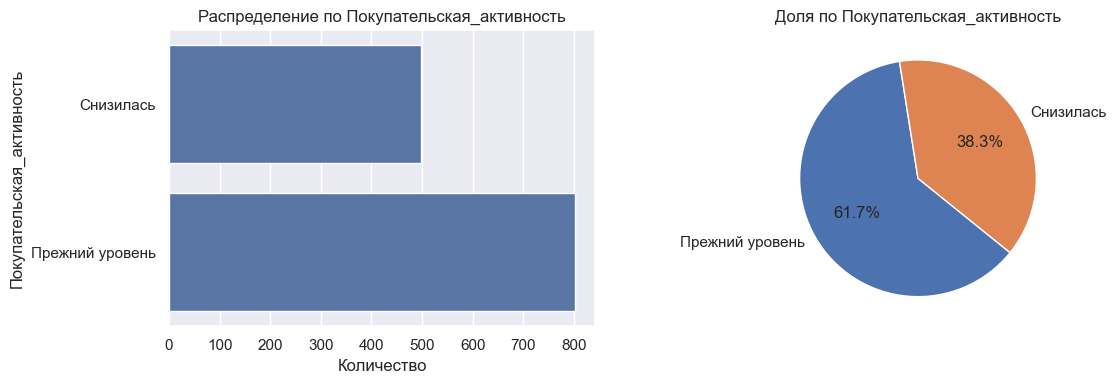

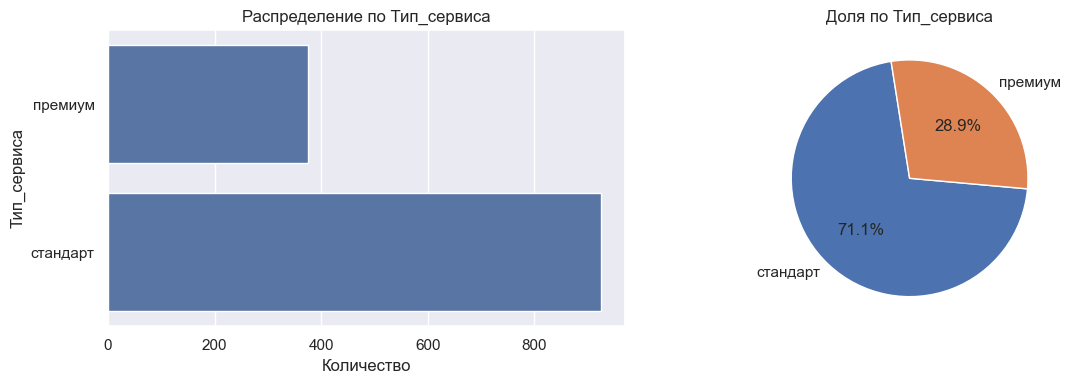

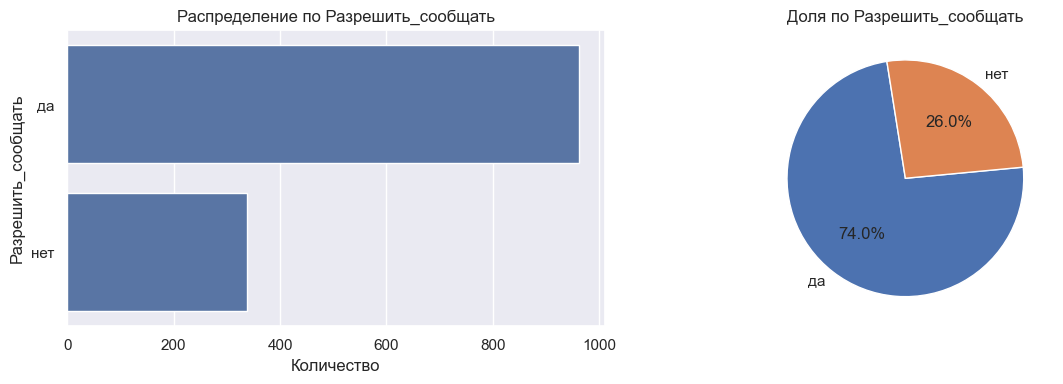

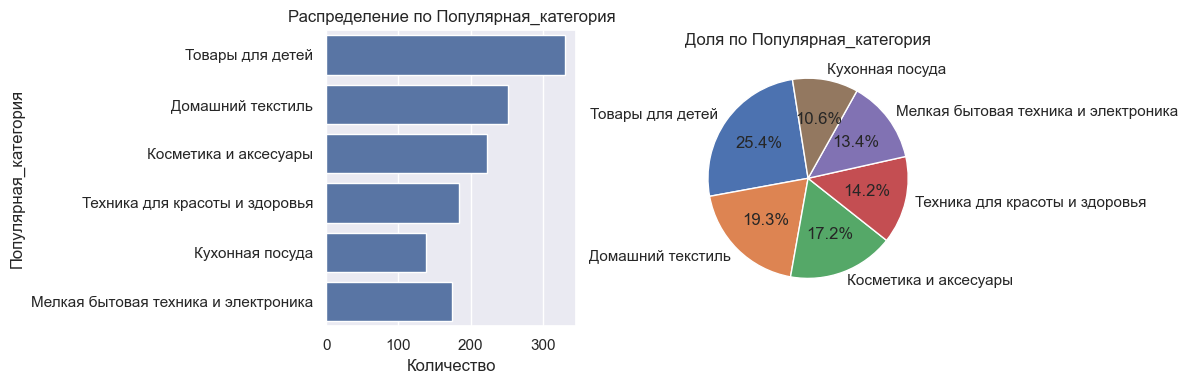

In [52]:
for j in cat_df1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 
    sns.countplot(data=df1, y=j, ax=ax1)
    ax1.set_title(f'Распределение по {j}')
    ax1.set_xlabel('Количество')
    
    value_counts = df1[j].value_counts()
    ax2.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=99)
    ax2.set_title(f'Доля по {j}')
    plt.subplots_adjust(wspace=1.3)  
    plt.tight_layout()
    plt.show()

**Разделим признак Акционные_покупки на два кластера. По идее для хороших мощных моделей типа деревьев это не надо, но для линейных может быть полезно**

In [53]:
df1['Акционные_покупки_уровень'] = (df1['Акционные_покупки'] > 0.6).map({True:'Акционные_Высокий_уровень',
                                                                         False:'Акционные_Низкий_уровень'})

### Статистический анализ market_money

**Описательные статистики market_money до обработки выбросов**:

In [54]:
df2['Выручка'].describe().to_frame().T

count     mean      std  min      25%      50%      75%        max
Выручка 3,900.00 5,025.70 1,777.70 0.00 4,590.15 4,957.50 5,363.00 106,862.20

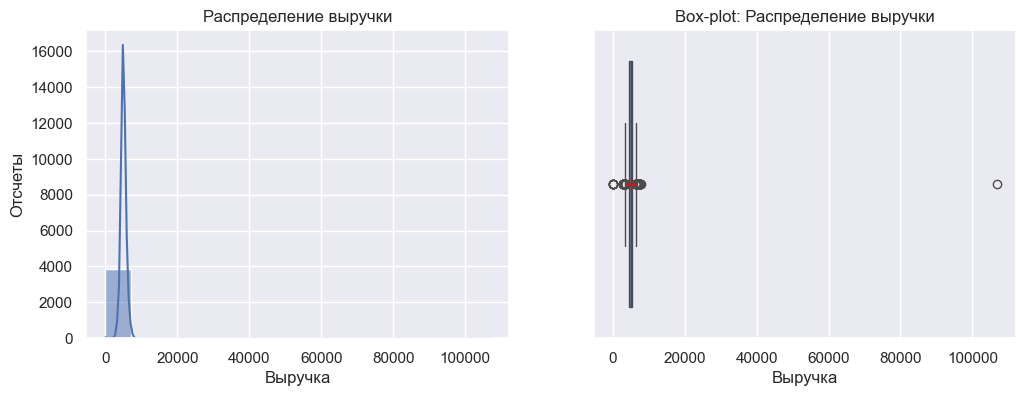

In [55]:

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
gg = sns.histplot(df2,x='Выручка', kde=True,bins=15)
plt.title('Распределение выручки')

plt.ylabel("Отсчеты")
plt.subplot(1, 2, 2)
sns.boxplot(data = df2,x='Выручка',orient='horizontal',
            showmeans=True,meanprops={'marker':'+','markeredgecolor':'red','markersize':'9' })
plt.title('Box-plot: Распределение выручки')
#plt.xlabel(j)
plt.show()

**Обнаружен выброс - скорее всего ошибка. Можно заменить значение средним**

In [56]:
# исправление выброса. меняем на среднее
df2.loc[df2['Выручка']>10000,'Выручка'] = df2.loc[df2['Выручка']<10000,'Выручка'].mean()

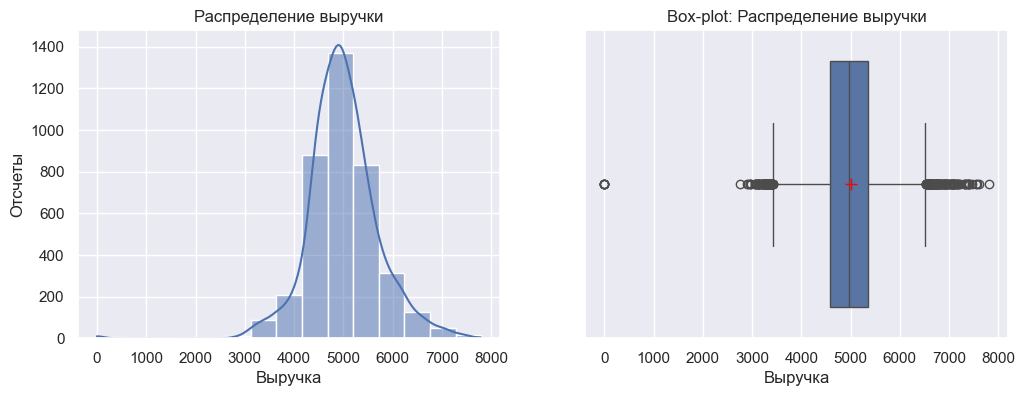

In [57]:
plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
gg = sns.histplot(df2,x='Выручка', kde=True,bins=15)
plt.title('Распределение выручки')
#plt.xlabel(mesur[i])
plt.ylabel("Отсчеты")
plt.subplot(1, 2, 2)
sns.boxplot(data = df2,x='Выручка',orient='horizontal',
            showmeans=True,meanprops={'marker':'+','markeredgecolor':'red','markersize':'9' })
plt.title('Box-plot: Распределение выручки')
#plt.xlabel(j)
plt.show()

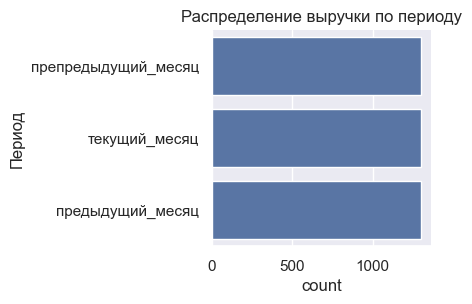

count     %
Период                          
препредыдущий_месяц   1300 33.33
текущий_месяц         1300 33.33
предыдущий_месяц      1300 33.33

In [58]:
g = sns.catplot(data=df2, y='Период', kind="count",height=3,aspect=1.5)

plt.title('Распределение выручки по периоду')

plt.show()
qw = pd.DataFrame(df2['Период'].value_counts())
qw['%'] = qw.iloc[:,0] / qw.iloc[:,0].sum() * 100
display(qw)

**Клиенты с активностью менее 3-х месяцев:**

In [59]:
nul_q = list(set(df2[df2['Выручка']==0]['id']))
print('id клиентов с активностью меньше 3-х месяцев:',nul_q)

id клиентов с активностью меньше 3-х месяцев: [215348, 215357, 215359]


In [60]:
df2[df2['Выручка']==0]

id               Период  Выручка
0   215348  препредыдущий_месяц     0.00
2   215348     предыдущий_месяц     0.00
28  215357  препредыдущий_месяц     0.00
29  215357     предыдущий_месяц     0.00
34  215359     предыдущий_месяц     0.00
35  215359  препредыдущий_месяц     0.00

**Наверное можно удалить данных клиентов, поскольку они сильно выбиваются из общего распределения**

In [61]:
df2 = df2[~df2['id'].isin(nul_q)]

In [62]:
df2

id               Период  Выручка
3     215349  препредыдущий_месяц 4,472.00
4     215349        текущий_месяц 4,971.60
5     215349     предыдущий_месяц 5,216.00
6     215350  препредыдущий_месяц 4,826.00
7     215350        текущий_месяц 5,058.40
...      ...                  ...      ...
3895  216646  препредыдущий_месяц 4,725.00
3896  216646     предыдущий_месяц 4,923.00
3897  216647     предыдущий_месяц 4,720.00
3898  216647  препредыдущий_месяц 5,183.00
3899  216647        текущий_месяц 4,448.30

[3891 rows x 3 columns]

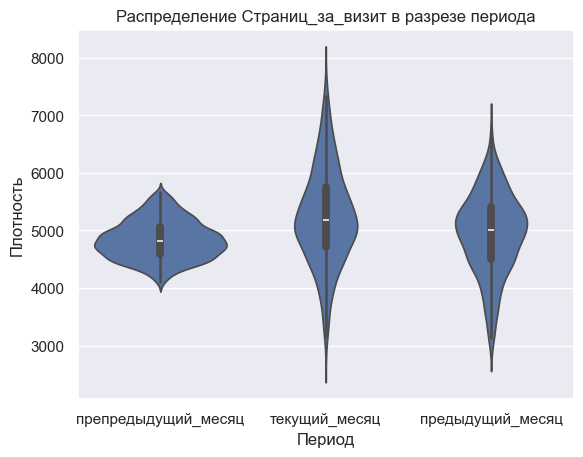

In [63]:
plt.title('Распределение Страниц_за_визит в разрезе периода')
plt.ylabel('Плотность')
sns.violinplot(x='Период', y='Выручка', data=df2)
plt.show()

**Описательные статистики после обработки выбросов**:

In [64]:
df2['Выручка'].describe().to_frame().T

count     mean    std      min      25%      50%      75%      max
Выручка 3,891.00 5,007.54 679.15 2,758.70 4,592.00 4,959.00 5,363.00 7,799.40

### Статистический анализ market_time

In [65]:
#описательные статистики
df3['минут'].describe().to_frame().T

count  mean  std  min   25%   50%   75%   max
минут 2,600.00 13.34 4.08 4.00 10.00 13.00 16.00 23.00

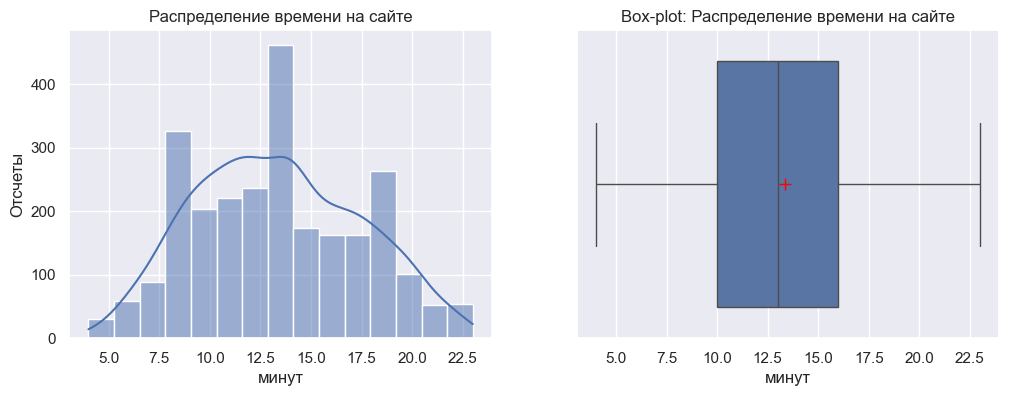

In [66]:

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
gg = sns.histplot(df3,x='минут', kde=True,bins=15)
plt.title('Распределение времени на сайте')
#plt.xlabel(mesur[i])
plt.ylabel("Отсчеты")
plt.subplot(1, 2, 2)
sns.boxplot(data = df3,x='минут',orient='horizontal',
            showmeans=True,meanprops={'marker':'+','markeredgecolor':'red','markersize':'9' })
plt.title('Box-plot: Распределение времени на сайте')
#plt.xlabel(j)
plt.show()

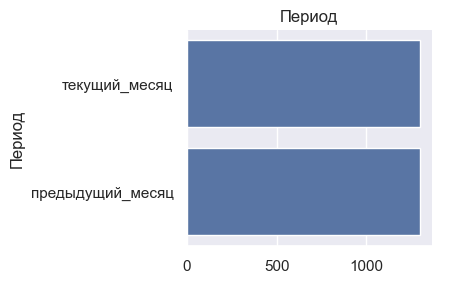

count     %
Период                       
текущий_месяц      1300 50.00
предыдущий_месяц   1300 50.00

In [67]:
g = sns.catplot(data=df3, y='Период', kind="count",height=3,aspect=1.5)

plt.title('Период')
plt.xlabel('')
plt.show()
qw = pd.DataFrame(df3['Период'].value_counts())
qw['%'] = qw.iloc[:,0] / qw.iloc[:,0].sum() * 100
display(qw)

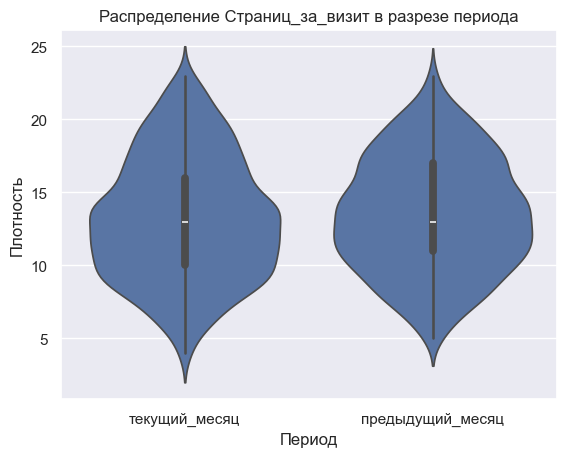

In [68]:
plt.title('Распределение Страниц_за_визит в разрезе периода')
plt.ylabel('Плотность')
sns.violinplot(x='Период', y='минут', data=df3)
plt.show()

### Статистический анализ money

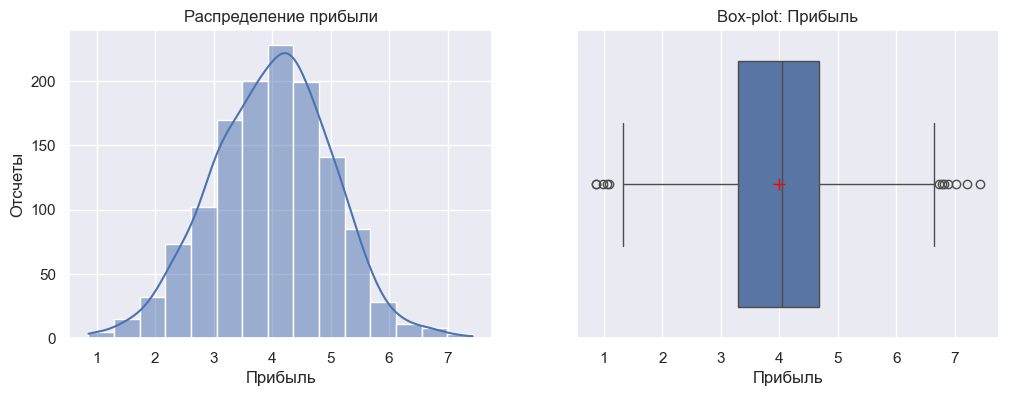

In [69]:

plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
gg = sns.histplot(df4,x='Прибыль', kde=True,bins=15)
plt.title('Распределение прибыли')
plt.ylabel("Отсчеты")
plt.subplot(1, 2, 2)
sns.boxplot(data = df4,x='Прибыль',orient='horizontal',
            showmeans=True,meanprops={'marker':'+','markeredgecolor':'red','markersize':'9' })
plt.title('Box-plot: Прибыль')
plt.show()

### Выводы по исследовательскому анализу

- выброс в данных "Выручка" исправлен (1 выброс заменен на среднее);


- удалены клиенты с активностью менее 3-х месяцев (3 клиента);


- введен категориальный признак "Акционные_покупки_уровень", поскольку распределение явно делится на два кластера;


Распределение прибыли и выручки носят гауссовский характер.

Распределение времени на сайте носит симметричный характер.

Большинство распределений признаков носят негауссовский характер, асиметричный.

Категориальный данные сильно несбалансированы:

- разрешение_сообщать(да / нет) : 74% / 26%;

- тип сервиса ((стандарт / премиум)): 71% / 29%;

**Таргет - "Покупательская активность" не сбалансирован в пользу "прежний уровень": 62% / 38%. Поэтому необходимо использовать стратификацию.**





## Объединение таблиц


In [70]:
#сводные таблицы для выделения каждого id пользователя
df33 = df3.pivot_table(index=['id'],
                                values='минут',
                                columns='Период')
df22 = df2.pivot_table(index=['id'],
                                values='Выручка',
                                columns='Период')

#переименуем столбцы в сводных таблицах 

df22 = df22.rename(columns={'предыдущий_месяц':'пред_мес_выруч','препредыдущий_месяц':'препредыдущий_месяц_выруч',
            'текущий_месяц':'текущ_мес_выруч'})
display(df22)
df33 = df33.rename(columns={'предыдущий_месяц':'предыдущий_месяц_мин',
            'текущий_месяц':'текущ_месяц_мин'})
display(df33)

Период  пред_мес_выруч  препредыдущий_месяц_выруч  текущ_мес_выруч
id                                                                
215349        5,216.00                   4,472.00         4,971.60
215350        5,457.50                   4,826.00         5,058.40
215351        6,158.00                   4,793.00         6,610.40
215352        5,807.50                   4,594.00         5,872.50
215353        4,738.50                   5,124.00         5,388.50
...                ...                        ...              ...
216643        3,664.00                   4,704.00         4,741.70
216644        4,729.00                   5,299.00         5,353.00
216645        5,160.00                   5,334.00         5,139.20
216646        4,923.00                   4,725.00         5,224.60
216647        4,720.00                   5,183.00         4,448.30

[1297 rows x 3 columns]

Период  предыдущий_месяц_мин  текущ_месяц_мин
id                                           
215348                 13.00            14.00
215349                 12.00            10.00
215350                  8.00            13.00
215351                 11.00            13.00
215352                  8.00            11.00
...                      ...              ...
216643                 14.00             7.00
216644                 12.00            11.00
216645                 12.00            18.00
216646                 18.00             7.00
216647                 15.00            10.00

[1300 rows x 2 columns]

In [71]:
#установка индекса в первой таблице
df1 = df1.set_index('id')

In [72]:
#Объединение таблиц
df = df22.join(df1.join(df33))
df.head()

пред_мес_выруч  препредыдущий_месяц_выруч  текущ_мес_выруч  \
id                                                                   
215349        5,216.00                   4,472.00         4,971.60   
215350        5,457.50                   4,826.00         5,058.40   
215351        6,158.00                   4,793.00         6,610.40   
215352        5,807.50                   4,594.00         5,872.50   
215353        4,738.50                   5,124.00         5,388.50   

       Покупательская_активность Тип_сервиса Разрешить_сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215353                 Снизилась    стандарт                 да   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215349                4.40                     4           819   
215350                4.90                     3           539   
215351                3.20                     5           896   
215352                5.10                     3          1064   
215353                3.30                     4           762   

        Акционные_покупки Популярная_категория  \
id                                               
215349               0.75     Товары для детей   
215350               0.14    Домашний текстиль   
215351               0.99     Товары для детей   
215352               0.94     Товары для детей   
215353               0.26    Домашний текстиль   

        Средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        Акционные_покупки_уровень  предыдущий_месяц_мин  текущ_месяц_мин  
id                                                                        
215349  Акционные_Высокий_уровень                 12.00            10.00  
215350   Акционные_Низкий_уровень                  8.00            13.00  
215351  Акционные_Высокий_уровень                 11.00            13.00  
215352  Акционные_Высокий_уровень                  8.00            11.00  
215353   Акционные_Низкий_уровень                 10.00            10.00

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1297 entries, 215349 to 216647
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   пред_мес_выруч                       1297 non-null   float64
 1   препредыдущий_месяц_выруч            1297 non-null   float64
 2   текущ_мес_выруч                      1297 non-null   float64
 3   Покупательская_активность            1297 non-null   object 
 4   Тип_сервиса                          1297 non-null   object 
 5   Разрешить_сообщать                   1297 non-null   object 
 6   Маркет_актив_6_мес                   1297 non-null   float64
 7   Маркет_актив_тек_мес                 1297 non-null   int64  
 8   Длительность                         1297 non-null   int64  
 9   Акционные_покупки                    1297 non-null   float64
 10  Популярная_категория                 1297 non-null   object 
 11  Средний_просмотр_категорий_з

In [74]:
#сбросим индексы (но сохраним id в отдельном столбце) для простоты дальнейшей обработки
df = df.reset_index()
df

id  пред_мес_выруч  препредыдущий_месяц_выруч  текущ_мес_выруч  \
0     215349        5,216.00                   4,472.00         4,971.60   
1     215350        5,457.50                   4,826.00         5,058.40   
2     215351        6,158.00                   4,793.00         6,610.40   
3     215352        5,807.50                   4,594.00         5,872.50   
4     215353        4,738.50                   5,124.00         5,388.50   
...      ...             ...                        ...              ...   
1292  216643        3,664.00                   4,704.00         4,741.70   
1293  216644        4,729.00                   5,299.00         5,353.00   
1294  216645        5,160.00                   5,334.00         5,139.20   
1295  216646        4,923.00                   4,725.00         5,224.60   
1296  216647        4,720.00                   5,183.00         4,448.30   

     Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0                    Снизилась     премиум                 да   
1                    Снизилась    стандарт                нет   
2                    Снизилась    стандарт                 да   
3                    Снизилась    стандарт                нет   
4                    Снизилась    стандарт                 да   
...                        ...         ...                ...   
1292           Прежний уровень    стандарт                 да   
1293           Прежний уровень    стандарт                нет   
1294           Прежний уровень    стандарт                 да   
1295           Прежний уровень    стандарт                 да   
1296           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
0                   4.40                     4           819   
1                   4.90                     3           539   
2                   3.20                     5           896   
3                   5.10                     3          1064   
4                   3.30                     4           762   
...                  ...                   ...           ...   
1292                6.60                     3           318   
1293                5.10                     4           454   
1294                4.10                     3           586   
1295                6.30                     5           645   
1296                4.00                     5           906   

      Акционные_покупки            Популярная_категория  \
0                  0.75                Товары для детей   
1                  0.14               Домашний текстиль   
2                  0.99                Товары для детей   
3                  0.94                Товары для детей   
4                  0.26               Домашний текстиль   
...                 ...                             ...   
1292               0.24  Техника для красоты и здоровья   
1293               0.21               Домашний текстиль   
1294               0.20               Домашний текстиль   
1295               0.12  Техника для красоты и здоровья   
1296               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                                       4                                   4   
1                                       5                                   2   
2                                       5                                   0   
3                                       3                                   2   
4                                       4                                   1   
...                                   ...                                 ...   
1292                                    5                                   3   
1293                                    6                                   2   
1294                                    3                                   2   
1295                        

## Корреляционный анализ

### Коэффициенты корреляции

In [75]:
num_df = df.select_dtypes(include=['number']).drop('id',axis=1).columns.to_list()  # Числовые признаки без id
cat_df = df.select_dtypes(include=['object']).columns.to_list()  # Категориальные признаки

In [76]:
#plt.figure(figsize=(10, 8)) 
#sns.heatmap(df[num_df].corr(), annot = True,cmap= 'coolwarm',fmt='.1f')
#plt.title('Корреляционная матрица (r-Пирсона)')
#plt.xticks(fontsize=10)
#plt.yticks(fontsize=10)
#plt.show()

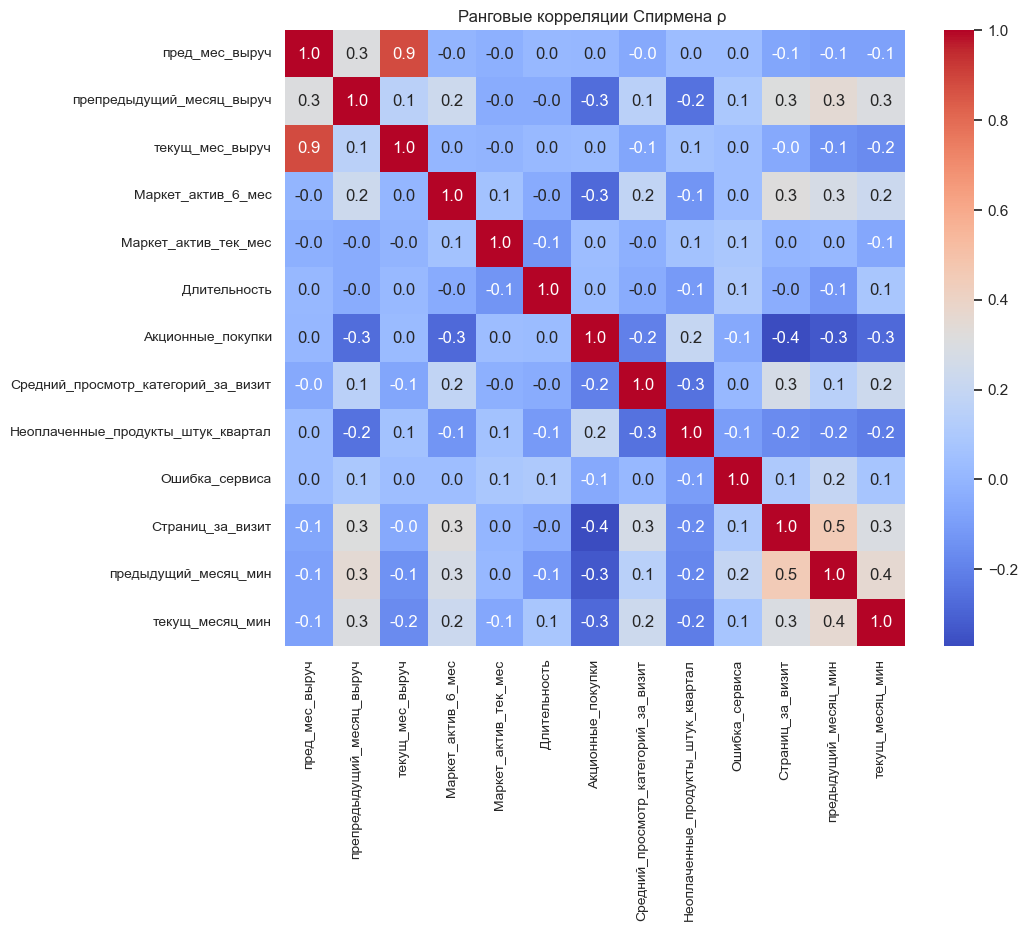

In [77]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(df[num_df].corr('spearman'), annot = True,cmap= 'coolwarm',fmt='.1f')
plt.title('Ранговые корреляции Спирмена ρ ')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Диаграммы рассеяния

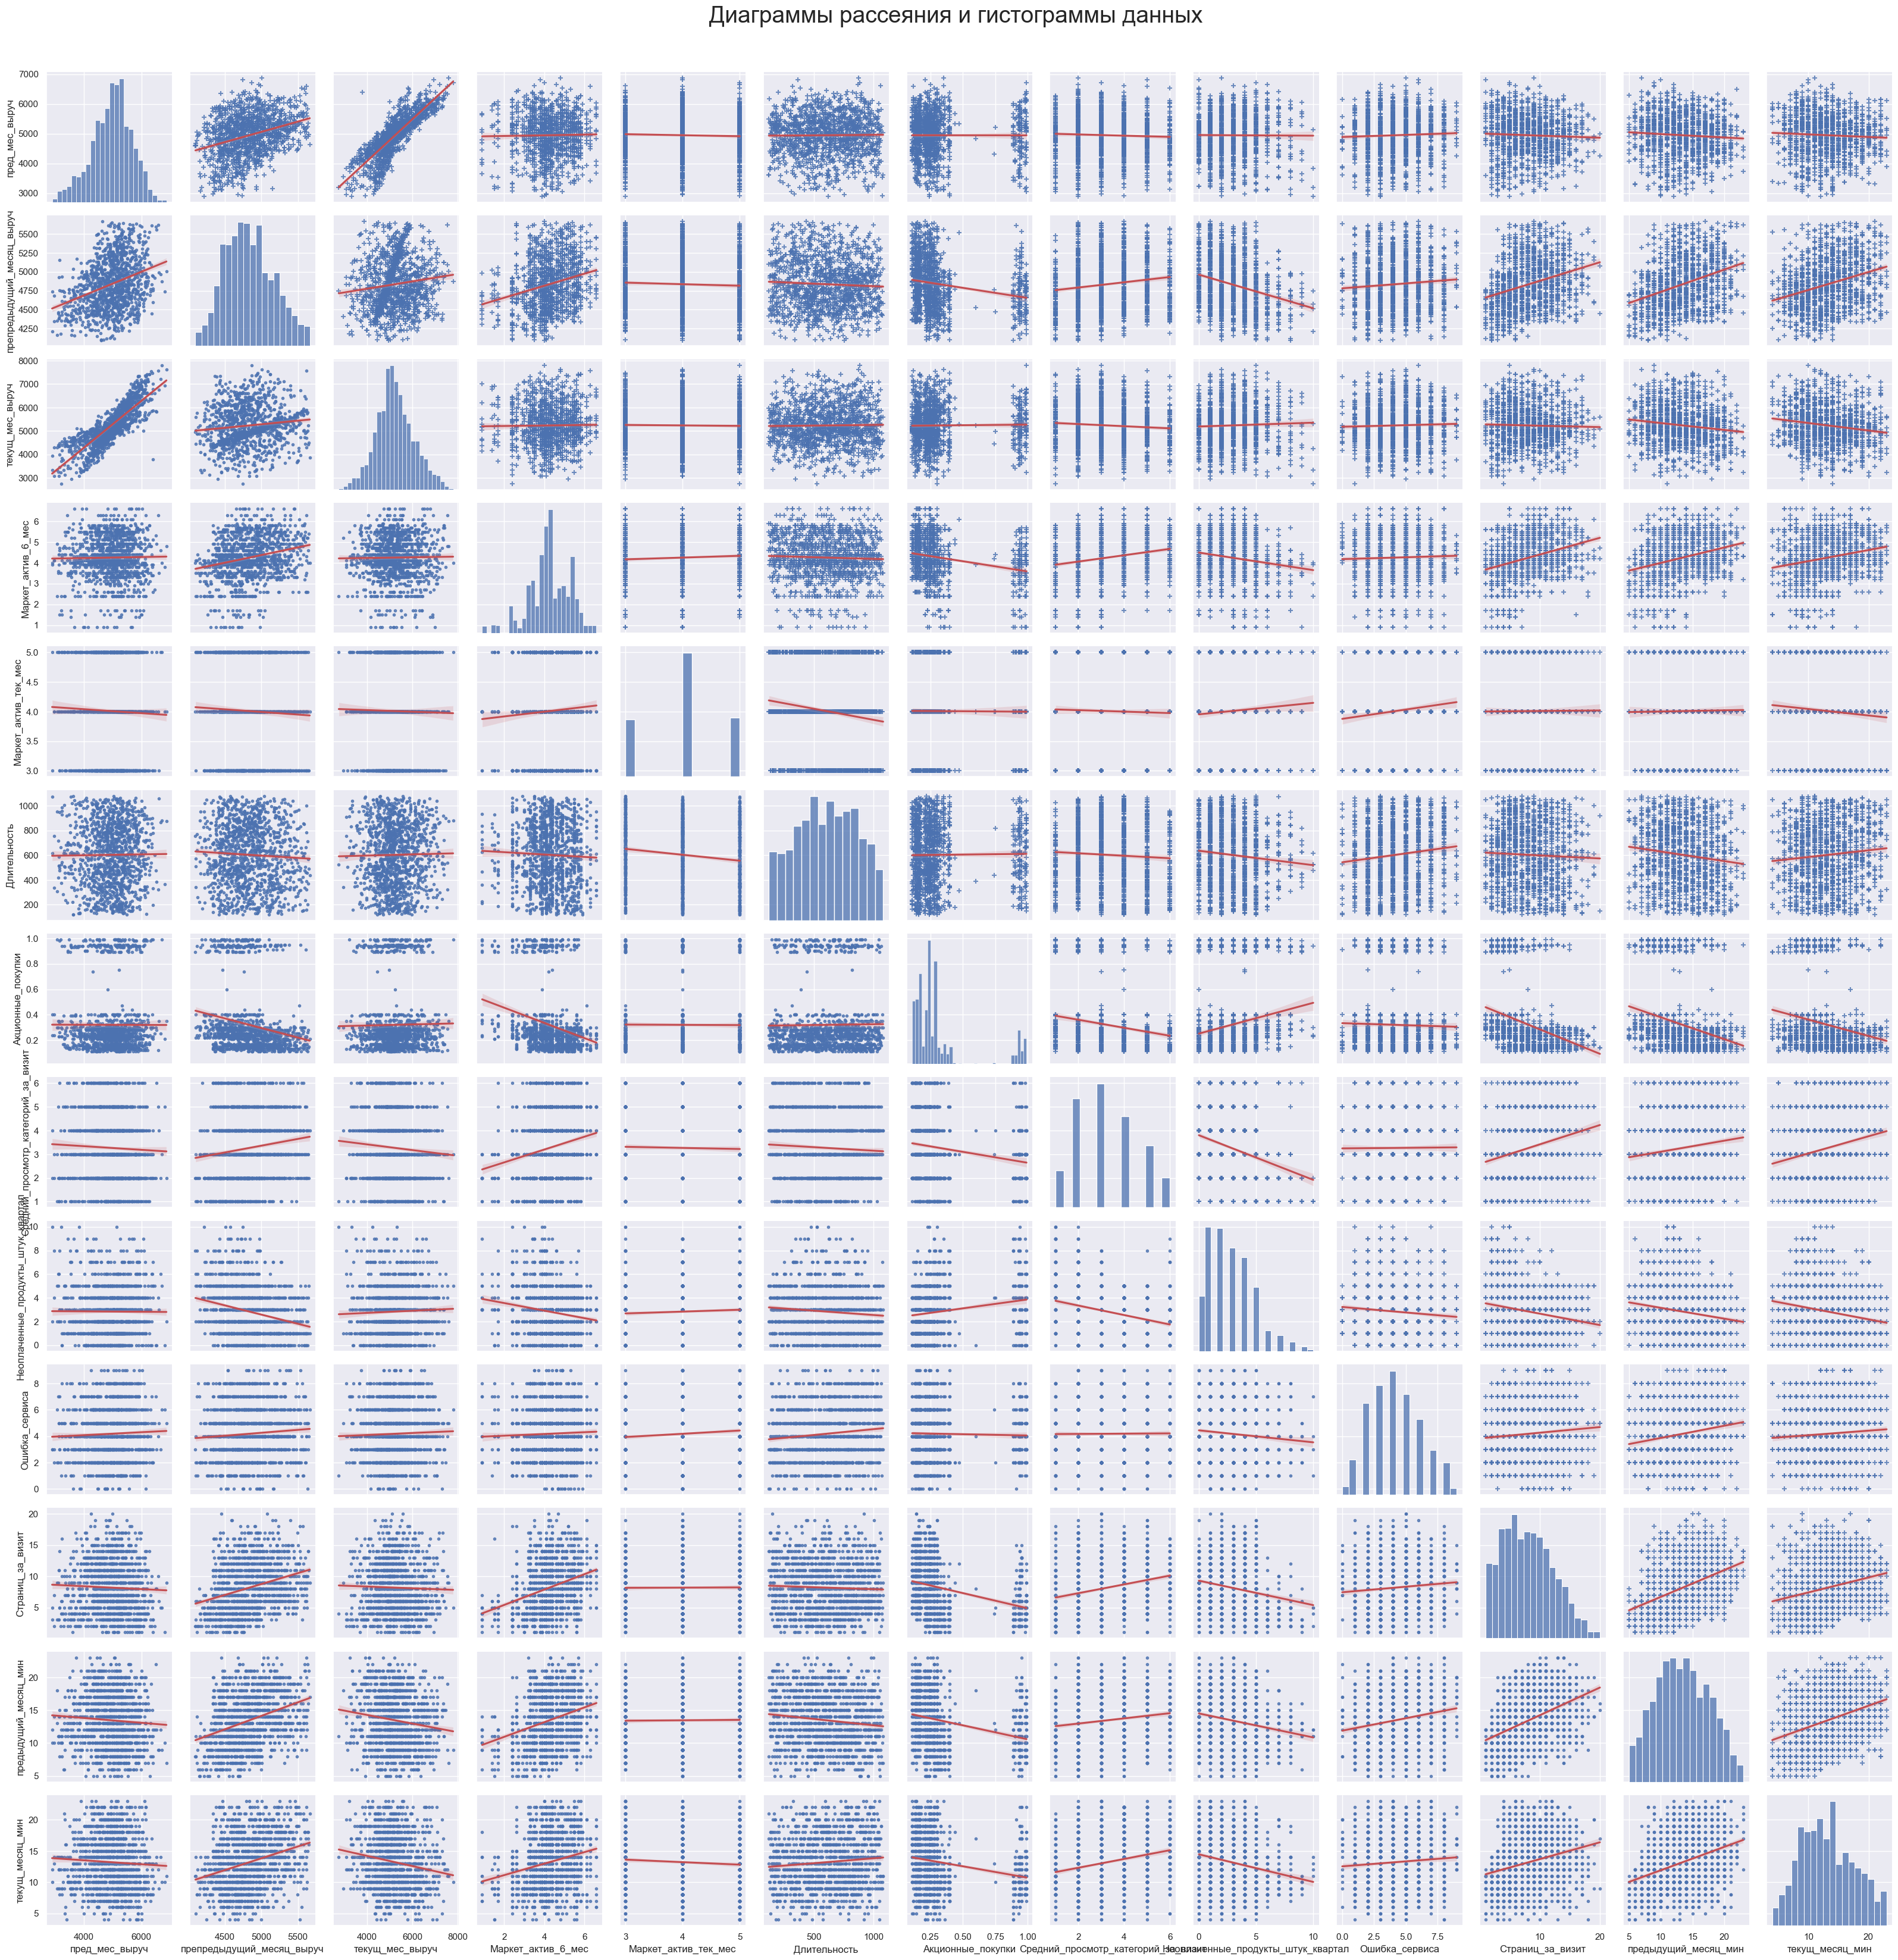

In [82]:
g = sns.PairGrid(df[num_df + cat_df], diag_sharey=False)
g.map_lower(sns.regplot,marker='.',line_kws=dict(color="r"))
g.map_upper(sns.regplot, marker='+',line_kws=dict(color="r"))
g.map_diag(sns.histplot)
plt.xlabel("Возраст, лет")
plt.ylabel("Частота")
plt.suptitle("Диаграммы рассеяния и гистограммы данных", y=1.02,fontsize = 28);
plt.show()

### Проверка на мультиколлинеарность

**Variance inflation factor**

Проверяем мультиколлинеарность только числовых признаков. Хотя по-хорошему надо проверять еще раз после кодирования категоральных.
(Не забываем, что добавили Акционные_покупки_уровень и надо оставить один из них)

In [83]:
S = df[num_df]

# Коэффициент перехвата (столбец из 1)

S = sm.add_constant(S)

# VIF

vif_data = pd.DataFrame()
vif_data["Variable"] = S.columns
vif_data["VIF"] = [variance_inflation_factor(S.values, i) for i in range(S.shape[1])]
vif_data


Variable    VIF
0                                 const 352.79
1                        пред_мес_выруч   4.24
2             препредыдущий_месяц_выруч   1.61
3                       текущ_мес_выруч   3.87
4                    Маркет_актив_6_мес   1.22
5                  Маркет_актив_тек_мес   1.04
6                          Длительность   1.10
7                     Акционные_покупки   1.19
8   Средний_просмотр_категорий_за_визит   1.18
9    Неоплаченные_продукты_штук_квартал   1.20
10                       Ошибка_сервиса   1.08
11                     Страниц_за_визит   1.42
12                 предыдущий_месяц_мин   1.53
13                      текущ_месяц_мин   1.32

**Наблюдается сильная корреляция между 'текущ_мес_выруч' и 'пред_мес_выруч'. Наблюдаюся высокие значения коэффициентов корреляции. И визуально на scatterplot. Возникает идея вообще сделать новый признак - суммарная выручка.
Но все же по анализу VIF эта зависимость не критична. Оставим все признаки. VIF < 5**

## Обучение моделей для классификации

### Выбор лучшей модели

In [84]:
# оставим в данных только категориальный признак Акционные_покупки_уровень, а Акционные_покупки удалим.
# данные
X = df.drop(['id','Покупательская_активность','Акционные_покупки'],axis=1)

# таргет
#y = df['Покупательская_активность'].map({'Снизилась':1,'Прежний уровень':0}) #закодировали таргет: 1,0

y = df['Покупательская_активность']

# разделение со стратификацией
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# кодирование таргета с помощью labelencoder
#'Снизилась':1,'Прежний уровень':0
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


In [85]:
# разделение признаков признаков
num_features = X.select_dtypes(include=['number']).columns.to_list()  # Числовые признаки
cat_features = X.select_dtypes(include=['object']).columns.to_list()  # Категориальные признаки


# Подготовка таблицы - предпроцессинг

#для OrdinalEncoder и OneHotEncoder

ohe_columns = cat_features.copy()
ohe_columns.remove('Акционные_покупки_уровень')
ord_columns = ['Акционные_покупки_уровень']

#для StandardScaler

num_columns1 = num_features.copy()
num_columns1.remove('Маркет_актив_тек_мес')

#для minmaxScaler

num_columns2 = ['Маркет_актив_тек_мес']
#выводим для проверки

print('Для OneHotEncoder:', ohe_columns)
print('')
print('Для OrdinalEncoder:', ord_columns)
print('')

print('Для StandardScaler:',num_columns1)
print('')

print('Для MinMaxScaler:', num_columns2)


Для OneHotEncoder: ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']

Для OrdinalEncoder: ['Акционные_покупки_уровень']

Для StandardScaler: ['пред_мес_выруч', 'препредыдущий_месяц_выруч', 'текущ_мес_выруч', 'Маркет_актив_6_мес', 'Длительность', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'предыдущий_месяц_мин', 'текущ_месяц_мин']

Для MinMaxScaler: ['Маркет_актив_тек_мес']


In [86]:
#Для всех моделей кроме дерева
data_preprocessor = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False), ohe_columns),
     ('ord', OrdinalEncoder(categories=[['Акционные_Низкий_уровень','Акционные_Высокий_уровень']]), ord_columns),
     ('num1', StandardScaler(), num_columns1),
     ('num2', MinMaxScaler(), num_columns2),
    ], 
    remainder='passthrough'
)
data_preprocessor.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Тип_сервиса', 'Разрешить_сообщать',
                                  'Популярная_категория']),
                                ('ord',
                                 OrdinalEncoder(categories=[['Акционные_Низкий_уровень',
                                                             'Акционные_Высокий_уровень']]),
                                 ['Акционные_покупки_уровень']),
                                ('num1', StandardScaler(),
                                 ['пред_мес_выруч', 'препредыдущий_месяц_выруч',
                                  'текущ_мес_выруч', 'Маркет_актив_6_мес',
                                  'Длительность',
                                  'Средний_просмотр_категорий_за_визит',
                                  'Неоплаченные_продукты_штук_квартал',
                                  'Ошибка_сервиса', 'Страниц_за_визит',
                                  'предыдущий_месяц_мин', 'текущ_месяц_мин']),
                                ('num2', MinMaxScaler(),
                                 ['Маркет_актив_тек_мес'])])

In [87]:
#Для дерева решений лучше так:
data_preprocessor_tree = ColumnTransformer(
    [('ord', OrdinalEncoder(), cat_features),
     ('num','passthrough',num_features)
    ], 
    remainder='passthrough'
)
data_preprocessor_tree.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('ord', OrdinalEncoder(),
                                 ['Тип_сервиса', 'Разрешить_сообщать',
                                  'Популярная_категория',
                                  'Акционные_покупки_уровень']),
                                ('num', 'passthrough',
                                 ['пред_мес_выруч', 'препредыдущий_месяц_выруч',
                                  'текущ_мес_выруч', 'Маркет_актив_6_мес',
                                  'Маркет_актив_тек_мес', 'Длительность',
                                  'Средний_просмотр_категорий_за_визит',
                                  'Неоплаченные_продукты_штук_квартал',
                                  'Ошибка_сервиса', 'Страниц_за_визит',
                                  'предыдущий_месяц_мин', 'текущ_месяц_мин'])])

In [ ]:
# все модели и параметры подбора
param_grid = [
    # Словарь для модели DecisionTreeClassifier()
   
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'preprocessor': [data_preprocessor_tree],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 6),
    },
    
    # Словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'preprocessor': [data_preprocessor],
        'models__n_neighbors': range(3,16),
        'models__metric':['euclidean','manhattan'] 
    },

    # Словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga', 
            penalty='l1'
        )],
        'preprocessor': [data_preprocessor],
        'models__C': [ 0.5,1,1.5,2,3,4],
         
    },
    
    
     
]


In [89]:
# Создание общего пайплайна
pipeline_final = Pipeline([
    ('preprocessor', data_preprocessor),  # Препроцессор будет подставляться динамически
    ('models', DecisionTreeClassifier())  # Модель будет подставляться динамически [DecisionTreeClassifier - заглушка]
])

**Данные целевого признака несбалансированы - для поиска лучшей модели будем использовать метрику f1 поскольку она хорошо подходит для несбалансированного таргета. Также можно было бы предложить как альтернативу roc_auс**

In [90]:
#поиск по сетке с метрикой f1
grid_search = GridSearchCV(
    pipeline_final, 
    param_grid, 
    cv=5,                   #кросс-валидация
    scoring='f1_weighted',  #метрика f1
                            #  random_state=RANDOM_STATE,
    n_jobs=-1
)

In [91]:
#поиск лучшей модели по сетке
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Тип_сервиса',
                                                                          'Разрешить_сообщать',
                                                                          'Популярная_категория']),
                                                                        ('ord',
                                                                         OrdinalEncoder(categories=[['Акционные_Низкий_уровень',
                                                                                                     'Акционные_Высокий_уровень']]),
                                                                         [...
                                                                           ('num1',
                                                                            StandardScaler(),
                                                                            ['пред_мес_выруч',
                                                                             'препредыдущий_месяц_выруч',
                                                                             'текущ_мес_выруч',
                                                                             'Маркет_актив_6_мес',
                                                                             'Длительность',
                                                                             'Средний_просмотр_категорий_за_визит',
                                                                             'Неоплаченные_продукты_штук_квартал',
                                                                             'Ошибка_сервиса',
                                                                             'Страниц_за_визит',
                                                                             'предыдущий_месяц_мин',
                                                                             'текущ_месяц_мин']),
                                                                           ('num2',
                                                                            MinMaxScaler(),
                                                                            ['Маркет_актив_тек_мес'])])]}],
             scoring='f1_weighted')

In [92]:
print('Лучшая модель и её параметры:', grid_search.best_estimator_.named_steps['models'])
print ('Метрика лучшей модели на тренировочной выборке (при кросс-валидации): f1 =', grid_search.best_score_)

Лучшая модель и её параметры: SVC(C=4, probability=True, random_state=42)
Метрика лучшей модели на тренировочной выборке (при кросс-валидации): f1 = 0.8837139365752392


### Применение модели к тестовой выборке

In [93]:
best_est = grid_search.best_estimator_


In [94]:
y_pred = best_est.predict(X_test)
y_pred_proba = best_est.predict_proba(X_test)[:,1]


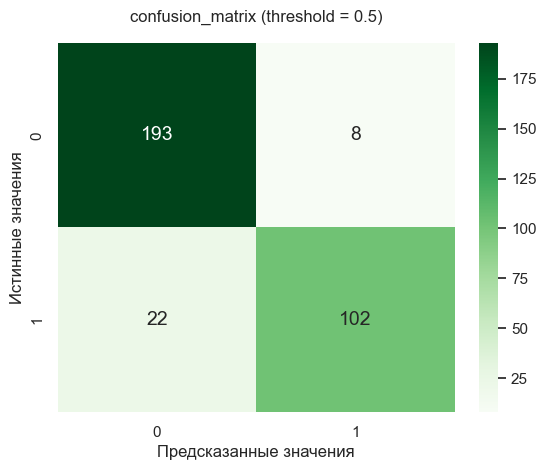

In [95]:
#матрица путаницы при пороге 0.5

sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14})
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('confusion_matrix (threshold = 0.5)', pad=15)
plt.show()

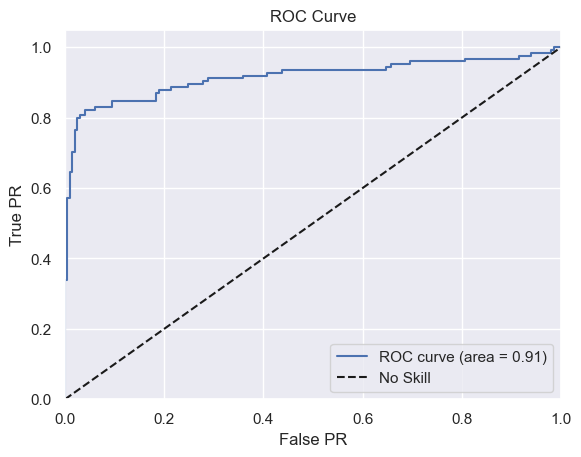

In [96]:
 # ROC кривая

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
  
# Plot the ROC curve
    
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False PR')
plt.ylabel('True PR')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [97]:
# метрики прогноза лучшей модели

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rocauc = roc_auc_score(y_test, y_pred_proba) 

kk0 = pd.DataFrame([recall,precision,accuracy,f1,rocauc],columns=['метрики'])
kk0.index = ['recall', 'precision','accuracy','f1','roc_auc']
kk0.T

recall  precision  accuracy   f1  roc_auc
метрики    0.82       0.93      0.91 0.87     0.91

**Проверка на адекватность - DummyClassifier**

In [98]:
# Создание и обучение DummyClassifier

dummy_model = DummyClassifier(strategy="most_frequent")  
dummy_model.fit(X_train, y_train)

# предсказание

y_pred_dummy = dummy_model.predict(X_test)

# метрики прогноза DummyClassifier

recall = recall_score(y_test, y_pred_dummy,zero_division=0)
precision = precision_score(y_test, y_pred_dummy,zero_division=0)
accuracy = accuracy_score(y_test, y_pred_dummy)
f1 = f1_score(y_test, y_pred_dummy)

kk0 = pd.DataFrame([recall,precision,accuracy,f1],columns=['метрики'])
kk0.index = ['recall', 'precision','accuracy','f1']
kk0.T

recall  precision  accuracy   f1
метрики    0.00       0.00      0.62 0.00

## Анализ важности признаков

### Важность признаков для лучшей модели и график важности с помощью метода SHAP

In [99]:
#обработка трансформером
X_train_transformed = data_preprocessor.fit_transform(X_train)
X_test_transformed = data_preprocessor.transform(X_test)

#выборка для быстроты
X_train_transformed_sample = X_train_transformed.sample(90, random_state=RANDOM_STATE)
X_test_transformed_sample = X_test_transformed.sample(30, random_state=RANDOM_STATE)



In [100]:
# Создаем explainer для модели SVC. 3 минуты!!!

explainer = shap.KernelExplainer(best_est.named_steps['models'].predict_proba, 
                                 X_train_transformed_sample)

shap_values = explainer(X_test_transformed_sample)

  0%|          | 0/30 [00:00<?, ?it/s]

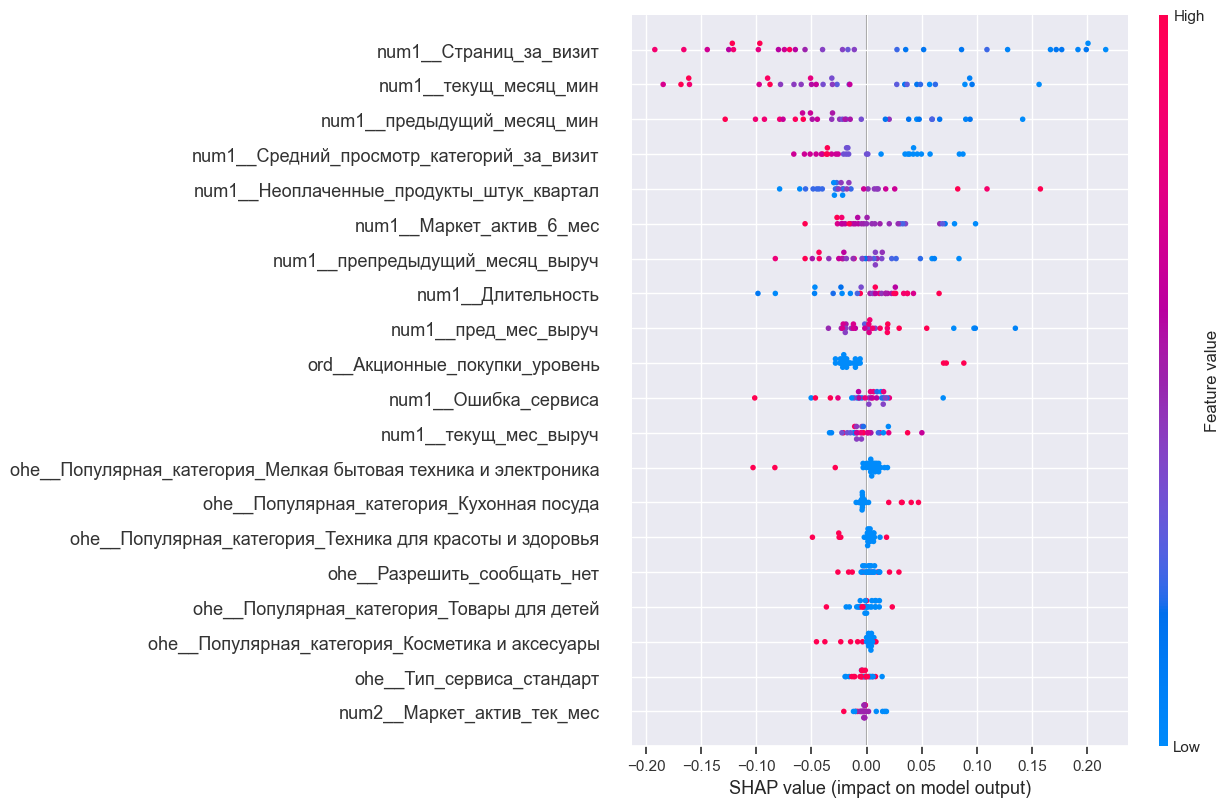

In [101]:
shap.plots.beeswarm(shap_values[:,:,1],max_display=100)

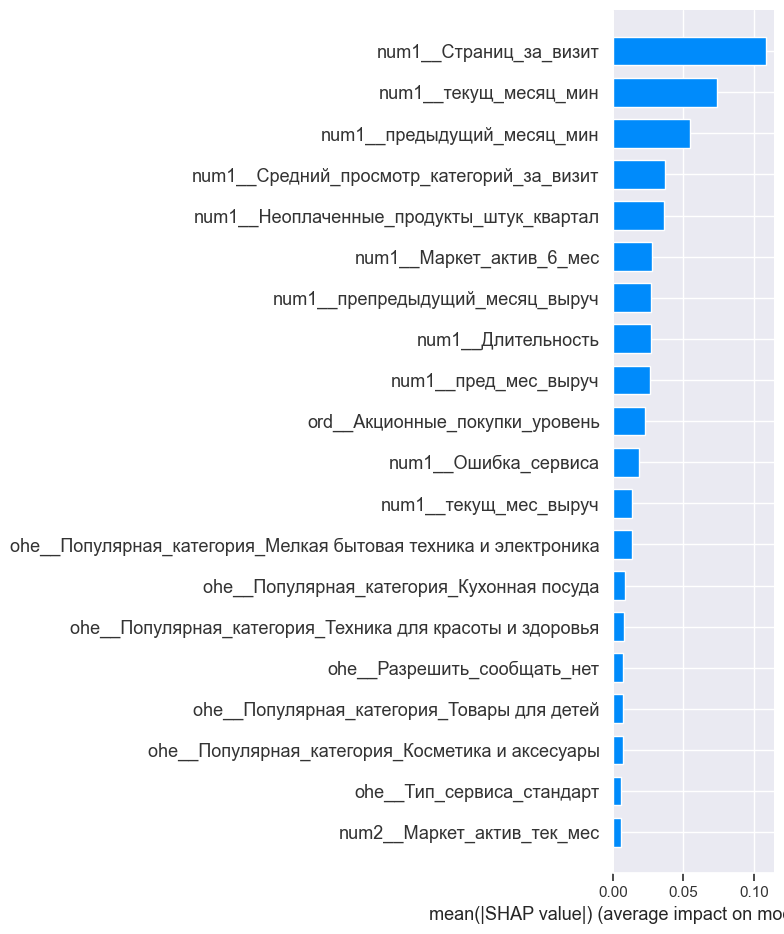

In [102]:

shap.summary_plot(shap_values[:,:,1], X_test_transformed_sample, plot_type="bar", max_display=100)



### Выводы о важности признаков

Тройка наименее важных признаков:

    - Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце;
    - Тип_сервиса;
    - Разрешить_сообщать;
    
5 наиболее важных признаков:

    - Страниц за визит;
    - Текущ_мес_мин;
    - Предыдущий_мес_мин;
    - Неоплаченные продукты;
    - Средний просмотр категорий за визит.

- Данный анализ можно использовать, чтобы эффективно определять тех, кто потенциально теряет активность, например, имеет неоплаченные товары в корзине или просматривает мало страниц (мало времени на сайте).

- Выводы модели вполне логичны - кто больше времени проводит на сайте и просматривает больше страниц, готов больше покупать. 

- Интересно, что тип сервиса не влияет на вероятность и похоже, что рекламные рассылки не работают - они не влияют на вероятность. 

- Категории товаров слабо влияют на результат и вряд ли должны использоваться для мониторинга.

- Также видно, что фактор Длительность (время от регистрации) занимает 6 место и чем больше он, тем больше вероятность падения активности.

- Маркет_актив6мес — среднемесячное значение маркетинговых коммуникаций компании безусловно оказывает положительно влияние, но по важности находится на 8-м месте. 

Таким образом, используя наиболее важные факторы магазин может обратить внимание именно на эти факторы - главное постараться, чтобы покупатель побольше проводил времени на сайте и безусловно увеличить маркетинговые коммуникации.

## Сегментация покупателей

In [103]:
#добавляем вероятность и прибыль в столбец общей таблицы
probability = best_est.predict_proba(X)[:,1]
df['Вероятность_снижения'] = probability
df_profit = df.merge(df4,on='id')

In [104]:
df_profit.head()

id  пред_мес_выруч  препредыдущий_месяц_выруч  текущ_мес_выруч  \
0  215349        5,216.00                   4,472.00         4,971.60   
1  215350        5,457.50                   4,826.00         5,058.40   
2  215351        6,158.00                   4,793.00         6,610.40   
3  215352        5,807.50                   4,594.00         5,872.50   
4  215353        4,738.50                   5,124.00         5,388.50   

  Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0                 Снизилась     премиум                 да   
1                 Снизилась    стандарт                нет   
2                 Снизилась    стандарт                 да   
3                 Снизилась    стандарт                нет   
4                 Снизилась    стандарт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  ...  \
0                4.40                     4           819  ...   
1                4.90                     3           539  ...   
2                3.20                     5           896  ...   
3                5.10                     3          1064  ...   
4                3.30                     4           762  ...   

   Популярная_категория Средний_просмотр_категорий_за_визит  \
0      Товары для детей                                   4   
1     Домашний текстиль                                   5   
2      Товары для детей                                   5   
3      Товары для детей                                   3   
4     Домашний текстиль                                   4   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   

   Акционные_покупки_уровень предыдущий_месяц_мин  текущ_месяц_мин  \
0  Акционные_Высокий_уровень                12.00            10.00   
1   Акционные_Низкий_уровень                 8.00            13.00   
2  Акционные_Высокий_уровень                11.00            13.00   
3  Акционные_Высокий_уровень                 8.00            11.00   
4   Акционные_Низкий_уровень                10.00            10.00   

   Вероятность_снижения  Прибыль  
0                  0.96     4.16  
1                  0.88     3.13  
2                  0.78     4.87  
3                  0.94     4.21  
4                  0.86     3.95  

[5 rows x 21 columns]

Выделим сегмент покупателей с прибылью выше средней и с высокой вероятностью снижения активности. Данные покупатели самые ценные для магазина. Сравним их покупателями с высокой прибылью, но с низкой вероятностью.

In [105]:
log1 = ((df_profit['Прибыль'] > df_profit['Прибыль'].mean()) & (df_profit['Вероятность_снижения'] > 0.8)).astype(int)

In [106]:
df_profit['Сегмент_важные_покупатели'] = log1

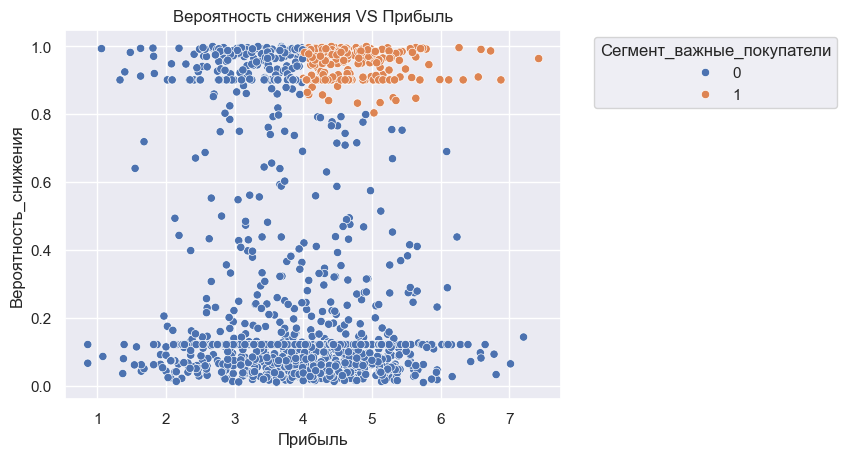

In [107]:
ax = sns.scatterplot(data=df_profit,y='Вероятность_снижения',x='Прибыль',hue='Сегмент_важные_покупатели')
plt.title('Вероятность снижения VS Прибыль')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title='Сегмент_важные_покупатели')


plt.show()

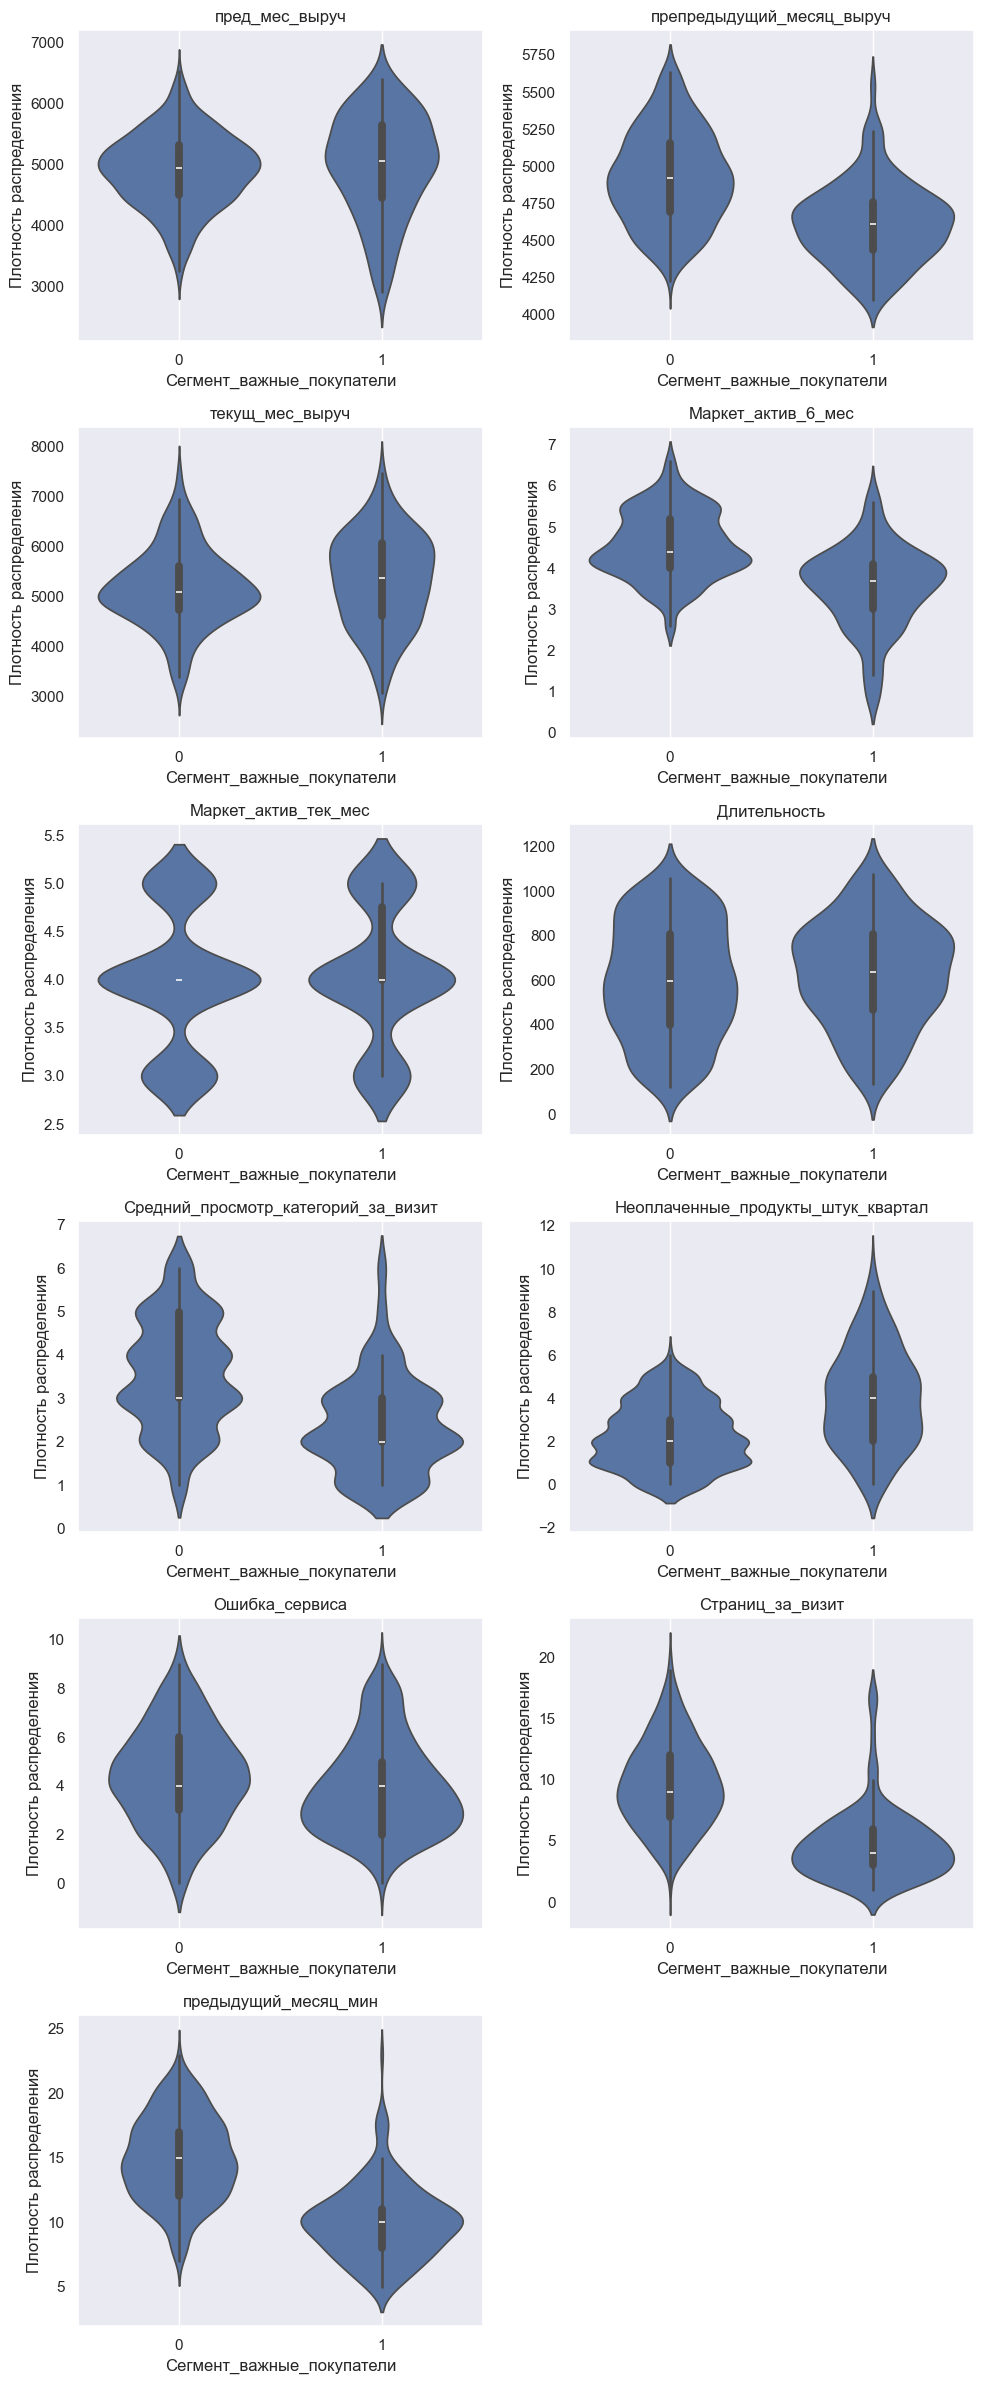

In [108]:
num_plots = 13
num_rows = 6
# Создаем сетку подграфиков
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 4 * num_rows))

fig.delaxes(axes[-1, -1])

# Проходим по каждому признаку и строим графики
for i, category in enumerate(num_features):
    # Определяем позицию subplot
    row = i // 2
    col = i % 2
    
    # Строим violinplot на соответствующем subplot
    sns.violinplot(ax=axes[row, col], x='Сегмент_важные_покупатели', y=category, 
                   data=df_profit[(df_profit['Прибыль'] > df_profit['Прибыль'].mean())])
    
    # Настраиваем заголовок и подписи
    axes[row, col].set_title(category)
    axes[row, col].set_ylabel("Плотность распределения")
    axes[row, col].grid()

# Убираем лишние отступы и показываем графики
plt.tight_layout()
plt.show()

Построим распределения числовых признаков в двух кластерах: c большой вероятность и с малой.

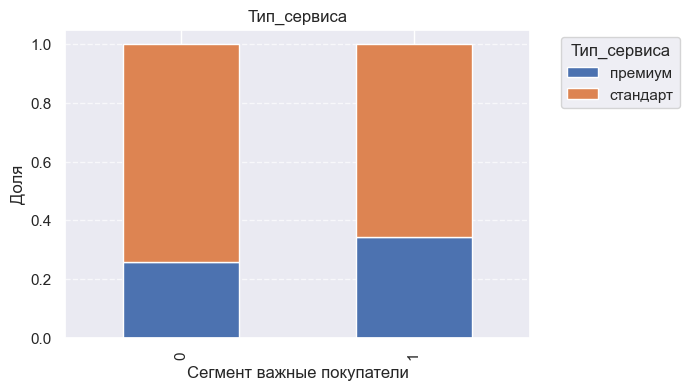

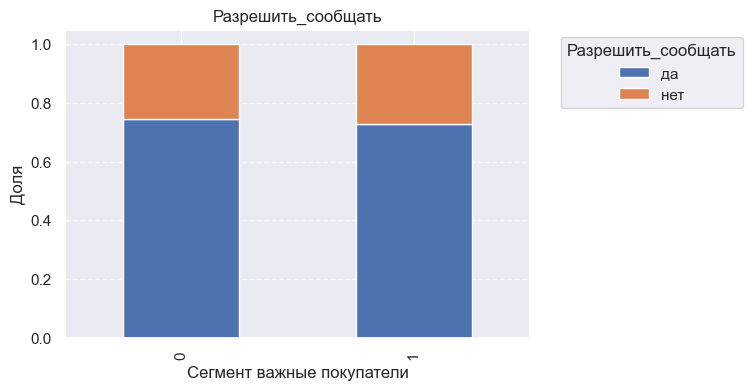

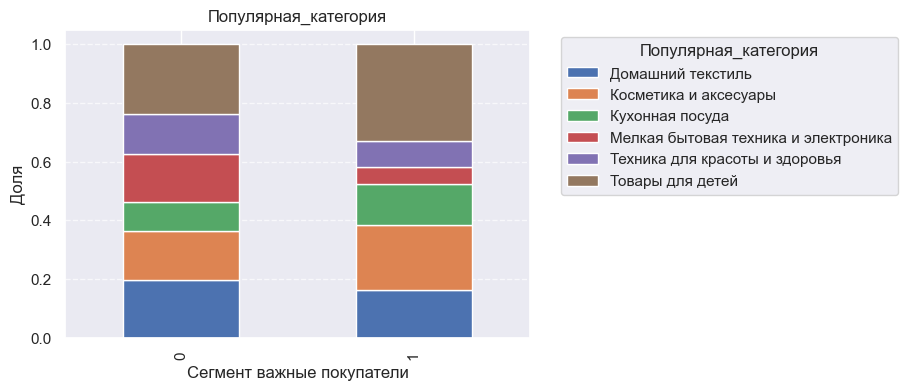

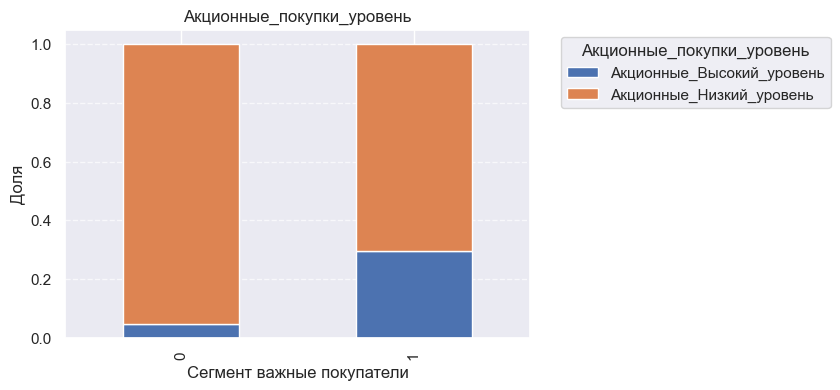

In [109]:

df0 = df_profit[(df_profit['Прибыль'] > df_profit['Прибыль'].mean())]

for i, category in enumerate(cat_features):
    # 
    grouped = df0.groupby(['Сегмент_важные_покупатели', category]).size().unstack(fill_value=0)
    grouped = grouped.div(grouped.sum(axis=1), axis=0)  # Нормализуем по строкам (сумма = 1)
    grouped.plot(kind='bar', stacked=True, figsize=(6, 4))
    # Настройки графика
    plt.title(category)
    plt.ylabel('Доля')
    plt.xlabel('Сегмент важные покупатели')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title=category)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### Выводы о сегментах:


Для изучения был выбран сегмент покупателей, которые имеют прибыль выше среднего и высокую вероятность снижения покупательской активности.


Исходя из узучения данного сегмента, можно рекомендовать удерживать клиентов на сайте. Чем больше клиент проводит времени на сайте, тем больше он покупает. 

Так же видно, что для данного сегмента среднее значение Маркет_актив6мес (среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев)  меньше, чем для конкурирующего сегомента (3.5 против 4.6). Поэтому рекомендуется увеличить маркетинговые коммуникации.



## Общий вывод

Интернет-магазином «В один клик» была поставлена цель: разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. Магазином были предоставлены базы данных по клиентам (1300 клиетов). Было решено построить и обучить несколько моделей ML и выбрать наиболее подходящую для прогнозирования вероятности снижения активности клиента.

В рамках работы были проделаны следующие шаги:

Предобработка данных:

- исправлены неявные дубликаты в таблице market_file;

- пропусков нет, полных дубликатов нет;

- изменены названия некоторых столбцов - чтобы не было пробелов.

Исследовательский анализ показал, что категориальные данные носят не сблансированный характер и также:

- выброс в данных "Выручка" исправлен (1 выброс заменен на среднее);

- удалены клиенты с активностью менее 3-х месяцев (3 клиента);

- введен категориальный признак "Акционные_покупки_уровень", поскольку распределение явно делится на два кластера;

Данные были поделены на тренировочную и тестовую выборки с учетом стратификации.
Были рассмотрены  4 модели для классификации: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Был проведен подбор гиперпараметров и найдена лучшая модель по метрике f1_score с учетом крос-валидации. Лучшая модель: опорные вектора с rbf ядром (SVC(C=4, probability=True, random_state=42)).

На тренеровочной выборке лучшая модель показала: f1_score = 0.87.

С помощью метода shap были оценены важные признаки:
5 наиболее важных признаков:

    - Страниц за визит;
    - Текущ_мес_мин;
    - Предыдущий_мес_мин;
    - Неоплаченные продукты;
    - Средний просмотр категорий за визит.
    
Используя модель для прогнозирования вероятности снижения активности и данные о прибыли был изучен сегмент покупателей, которые имеют прибыль выше среднего и высокую вероятность снижения покупательской активности.


Исходя из узучения данного сегмента, можно рекомендовать удерживать клиентов на сайте. Чем больше клиент проводит времени на сайте, тем больше он покупает. 

Так же видно, что для данного сегмента среднее значение Маркет_актив6мес (среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев)  меньше, чем для конкурирующего сегомента (3.5 против 4.6). Поэтому рекомендуется увеличить маркетинговые коммуникации с этими клиентами.




